In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Requirement 1
## Stochastic environments


## Bidding Environment

In [8]:
# auction blueprint
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


# second price auctions are truthful (bid == value) 
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        # ctrs = click-through rates (ad quality)
        self.ctrs = ctrs
        # assumed to be known by the auctioneer (can estimate them)
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        # we compute the expected utility of each ad for the advertiser
        adv_values = self.ctrs*bids
        # sort the values in ascending order
        adv_ranking = np.argsort(adv_values)
        # the winner is chosen both based on its bid and the ad's ctr
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        # apply formula for payment of second price auctions
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

## Learning optimal bid

In [9]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 4
n_users = 1000
B = 150

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 10*B/n_users, size = (n_advertisers, n_users))
# I assume that competitors may have a larger budget than mine (10*B), but they may not deplete it.

m_t = other_bids.max(axis=0) ### maximum bid at every round, NOT IN EXPECTATION

my_ctr = 0.85
my_valuation = 1

other_ctr = np.array([0.8, 0.95, 0.65, 0.75])
other_valuations = np.array([0.7, 1.1, 1.4, 0.85])

ctrs = np.append(my_ctr, other_ctr)

ctrs

# other_bids

array([0.85, 0.8 , 0.95, 0.65, 0.75])

In [10]:
### As a re-usable function:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    # the clairvoyant knows the max bid at each round
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    # recall that operations with ndarray produce ndarray

    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0 # total money spent
    i = 0 # index over the auctions
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1 # bid 1 in the remaining most profitable auction
        # recall that since this is a second-price auction what I pay doesn't depend on my bid (but determines if I win)
        # notice that since the competitors' bids are fixed < 1 the clairvoyant can just bid 1 to the auctions he wants to win and 0 to the rest
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

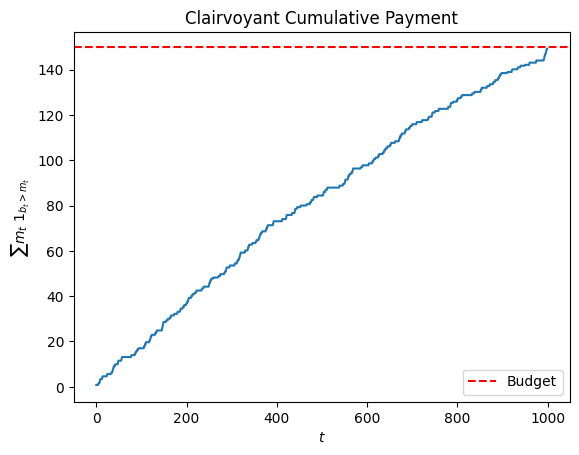

In [11]:
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

plt.title('Clairvoyant Cumulative Payment')
plt.plot(np.cumsum(clairvoyant_payments))
plt.axhline(B, color='red', linestyle='--', label='Budget')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$\sum m_t~ 1_{b_t > m_t}$')
plt.show();

In [12]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), # projection on [0, 1/rho]-> values smaller than 0 become 0 and higher than 1/rho become 1/rho
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

In [13]:
eta = 1/np.sqrt(n_users) # from theory
agent = MultiplicativePacingAgent(valuation=my_valuation,
                                  budget=B,
                                  T=n_users, 
                                  eta=eta)

auction = SecondPriceAuction(ctrs)

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(18) # for experiment reproducbility purposes
for u in range(n_users): # for each auction
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
    agent.update(f_t, c_t) # bandit feedback
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 146


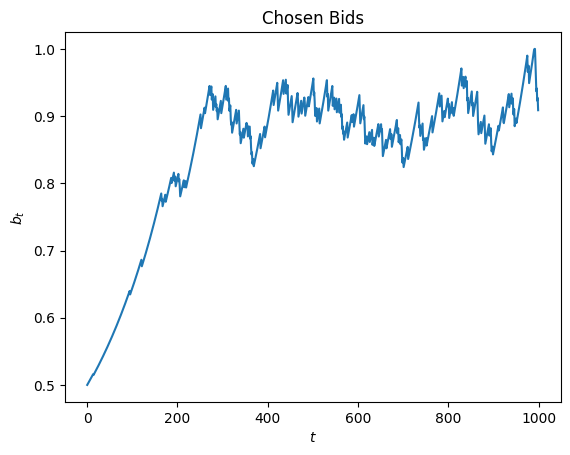

In [14]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

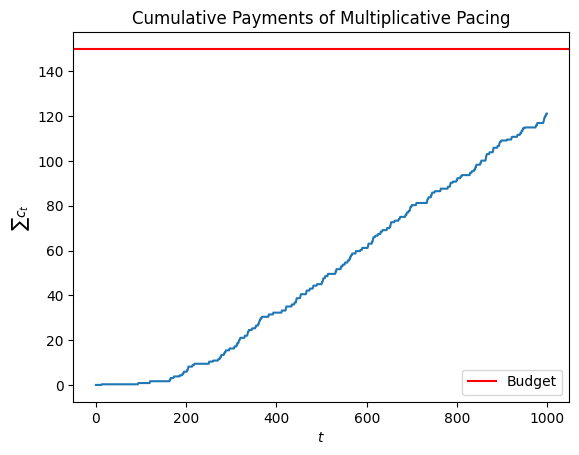

In [15]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

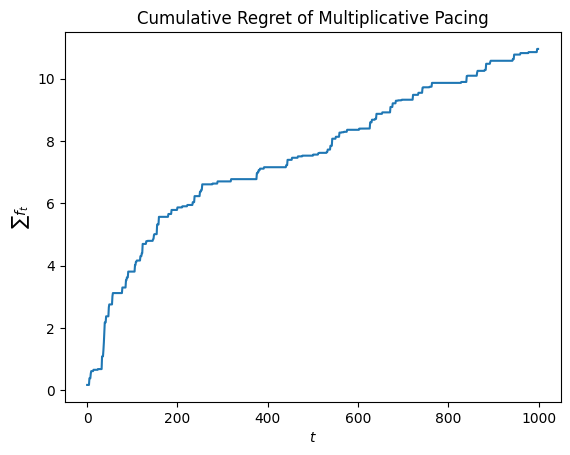

In [24]:
cumulative_regret = np.cumsum(clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum f_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

In [ ]:
class UCB1Agent(Agent):
    def __init__(self, B, bids, eta, T, range=1):
        self.K = len(bids)
        self.T = T
        self.range = range
        self.b_t = None
        self.f_avg = np.zeros(K)
        self.c_avg = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f = self.f_avg + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c = self.c_avg - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            # self.b_t = np.argmax(ucbs) solve LP to find best bid
        return self.b_t
    
    def update(self, f_t, c_t):
        self.N_pulls[self.b_t] += 1
        self.f_avg[self.b_t] += (f_t - self.average_rewards[self.b_t])/self.N_pulls[self.b_t]
        self.c_avg[self.b_t] += (c_t - self.average_rewards[self.b_t])/self.N_pulls[self.b_t]
        self.t += 1

## Pricing Environment

In [16]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

## Gaussian Process

In [17]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

## GP-UCB Agent

In [18]:
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        # all formulas are in the linked paper
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t  # beta inflates the confidence (?) encourages exploration (it is increasing in time)
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

### Demand Curve

In [19]:
conversion_probability = lambda p: 1-p/20
reward_function = lambda price, n_sales: (price-cost)*n_sales

### Environment Initialization

In [20]:
# maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x
    
T = 500
min_price, max_price = 10, 20
n_customers = 1
cost = 10
agent = GPUCBAgent(T)
np.random.seed(2)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# computation of the Clairvoyant

prices = np.linspace(min_price, max_price, 100)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)




## Learning demand curve

In [21]:
agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

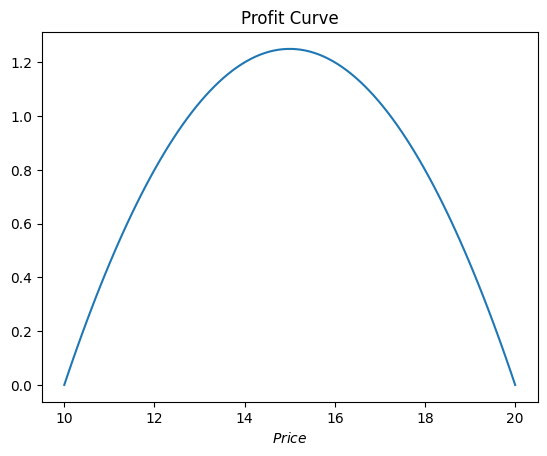

In [22]:
plt.figure()
plt.plot(prices, (prices - cost)*n_customers*conversion_probability(prices))
plt.title('Profit Curve')
plt.xlabel('$Price$')
plt.show()

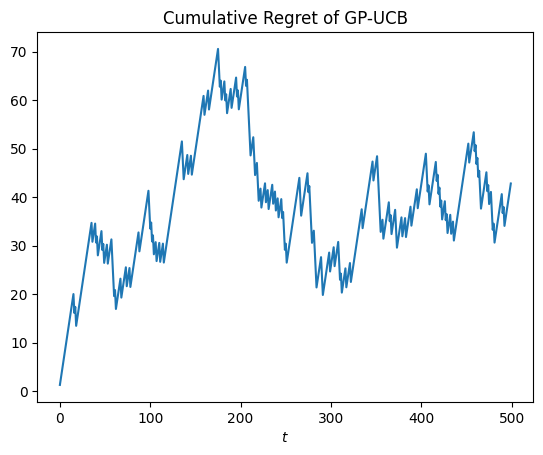

In [23]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show()